In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re


from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm




In [81]:
df = pd.read_csv("lego.population.csv", sep=",", encoding="latin1")
# fjerner forklaringsvariabler vi ikke trenger


df2 = df[
    ["Set_Name", "Theme", "Klassifisering", "Ages", "Price", "Pages", "Pieces",  "Unique_Pieces"]
]

# fjerner observasjoner med manglende datapunkter
df2 = df2.dropna()

klassifisering_mapping = { "B": 0, "N":1, "G": 2}
df2["Klassifisering_norm"] = df2["Klassifisering"].map(klassifisering_mapping)


# gjør themes om til string og fjern alle tegn vi ikke vil ha med
df2["Theme"] = df2["Theme"].astype(str)
df2["Theme"] = df2["Theme"].str.replace(r"[^a-zA-Z0-9\s-]", "", regex=True)

# fjerner dollartegn og trademark-tegn fra datasettet
df2["Price"] = df2["Price"].str.replace("\$", "", regex=True)

# og gjør så prisen om til float
df2["Price"] = df2["Price"].astype(float)

df2

,Set_Name,Theme,Klassifisering,Ages,Price,Pages,Pieces,Unique_Pieces,Klassifisering_norm
0,Batboat The Penguin Pursuit!,Batman,B,Ages_4+,9.99,44.0,54.0,41.0,0
1,Battle-Ready Batman and MetalBeard,Batman,B,Ages_6+,19.99,64.0,168.0,98.0,0
2,Batman vs. The Riddler Robbery,Batman,B,Ages_4+,9.99,36.0,59.0,44.0,0
3,Batman: The Attack of the Talons,Batman,B,Ages_7-12,19.99,60.0,155.0,82.0,0
4,Batman Batsub and the Underwater Clash,Batman,B,Ages_7+,19.99,64.0,174.0,82.0,0
...,...,...,...,...,...,...,...,...,...
1294,Death Star Final Duel,Star Wars,B,Ages_9+,99.99,140.0,775.0,241.0,0
1295,Resistance I-TS Transport,Star Wars,B,Ages_9+,99.99,140.0,932.0,215.0,0
1297,TIE Fighter Pilot,Star Wars,B,Ages_18+,59.99,148.0,724.0,155.0,0
1298,Y-wing Starfighter,Star Wars,B,Ages_14+,199.99,220.0,1967.0,359.0,0


In [82]:
def transform_ages(age_str):
    try:
        # Remove 'Ages_' prefix and any non-numeric characters except for '+' and '-'
        age_str = re.sub(r'Ages_|[^\d\+\-]', '', age_str).strip()
        # Split on '+' and take the first element (the actual age)
        age_str = age_str.split('+')[0]
        # Split on '-' to find ranges
        age_range = age_str.split('-')
        # If it's a range and the upper age is 99, use just the lower age
        if len(age_range) == 2 and age_range[1] == '99':
            return int(age_range[0])
        # If it's a range, calculate the average, otherwise use the single value
        elif len(age_range) == 2:
            return (int(age_range[0]) + int(age_range[1])) / 2
        else:
            return int(age_range[0])
    except ValueError as e:
        # Log the error and the problematic string
        print(f"Error converting {age_str} to int: {e}")
        return None  # Or some default value you deem appropriate
df2['Ages_norm'] = df2['Ages'].apply(transform_ages)

df2 = pd.get_dummies(df2, columns=['Theme'], drop_first=True)
# Normalize column names
df2.columns = [re.sub(r'[^a-zA-Z0-9_]', '', col) if not col.isalnum() else col for col in df2.columns]

# Convert 'Pages', 'Pieces', and 'Unique_Pieces' to float
df2[['Pages', 'Pieces', 'Unique_Pieces']] = df2[['Pages', 'Pieces', 'Unique_Pieces']].astype(float)

df2


,Set_Name,Klassifisering,Ages,Price,Pages,Pieces,Unique_Pieces,Klassifisering_norm,Ages_norm,Theme_Batman,...,Theme_PowerpuffGirls,Theme_SpeedChampions,Theme_SpiderMan,Theme_StarWars,Theme_StrangerThings,Theme_THELEGOMOVIE2,Theme_Technic,Theme_TrollsWorldTour,Theme_Unikitty,Theme_Xtra
0,Batboat The Penguin Pursuit!,B,Ages_4+,9.99,44.0,54.0,41.0,0,4.0,1,...,0,0,0,0,0,0,0,0,0,0
1,Battle-Ready Batman and MetalBeard,B,Ages_6+,19.99,64.0,168.0,98.0,0,6.0,1,...,0,0,0,0,0,0,0,0,0,0
2,Batman vs. The Riddler Robbery,B,Ages_4+,9.99,36.0,59.0,44.0,0,4.0,1,...,0,0,0,0,0,0,0,0,0,0
3,Batman: The Attack of the Talons,B,Ages_7-12,19.99,60.0,155.0,82.0,0,9.5,1,...,0,0,0,0,0,0,0,0,0,0
4,Batman Batsub and the Underwater Clash,B,Ages_7+,19.99,64.0,174.0,82.0,0,7.0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1294,Death Star Final Duel,B,Ages_9+,99.99,140.0,775.0,241.0,0,9.0,0,...,0,0,0,1,0,0,0,0,0,0
1295,Resistance I-TS Transport,B,Ages_9+,99.99,140.0,932.0,215.0,0,9.0,0,...,0,0,0,1,0,0,0,0,0,0
1297,TIE Fighter Pilot,B,Ages_18+,59.99,148.0,724.0,155.0,0,18.0,0,...,0,0,0,1,0,0,0,0,0,0
1298,Y-wing Starfighter,B,Ages_14+,199.99,220.0,1967.0,359.0,0,14.0,0,...,0,0,0,1,0,0,0,0,0,0


In [74]:
Q1 = df2['Price'].quantile(0.10)
Q3 = df2['Price'].quantile(0.90)
IQR = Q3 - Q1

# Define the upper and lower bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create df3 without outliers in the Price column
df3 = df2[(df2['Price'] >= lower_bound) & (df2['Price'] <= upper_bound)]


In [83]:
formel = 'Price ~ Pieces'

modell = smf.ols(formel, data = df2)
resultat = modell.fit()

resultat.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     23.92
Date:                Mon, 06 Nov 2023   Prob (F-statistic):           1.19e-06
Time:                        18:06:07   Log-Likelihood:                -5039.3
No. Observations:                 922   AIC:                         1.008e+04
Df Residuals:                     920   BIC:                         1.009e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              54.3660      2.403     22.622      0.000      49.650      59.082
Klassifisering_norm   -11.7398      2.401     -4.890      0.000     -16.451      -7.028
==============================================================================
Omnibus:                      838.081   Durbin-Watson:                   0.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31217.472
Skew:                           4.091   Prob(JB):                         0.00
Kurtosis:                      30.307   Cond. No.                         2.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

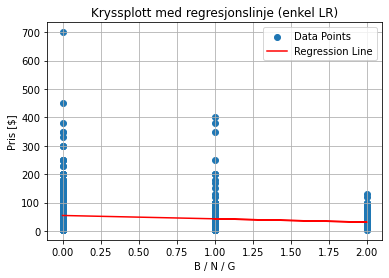

Set_Name                 Imperial Star Destroyer
Klassifisering                                 B
Ages                                    Ages_16+
Price                                     699.99
Pages                                      444.0
Pieces                                    4784.0
Unique_Pieces                              445.0
Klassifisering_norm                            0
Ages_norm                                   16.0
Theme_Batman                                   0
Theme_BrickHeadz                               0
Theme_City                                     0
Theme_Classic                                  0
Theme_Creator3in1                              0
Theme_CreatorExpert                            0
Theme_DC                                       0
Theme_DOTS                                     0
Theme_DUPLO                                    0
Theme_Disney                                   0
Theme_Friends                                  0
Theme_HarryPotter   

In [84]:
slope = resultat.params['Klassifisering_norm']
intercept = resultat.params['Intercept']

regression_x = np.array(df2['Klassifisering_norm'])

regression_y = slope * regression_x + intercept

plt.scatter(df2['Klassifisering_norm'], df2['Price'], label='Data Points')
plt.plot(regression_x, regression_y, color='red', label='Regression Line')
plt.xlabel('B / N / G')
plt.ylabel('Pris [$]')
plt.title('Kryssplott med regresjonslinje (enkel LR)')
plt.legend()
plt.grid()
plt.show()

print(df2.loc[df2['Price'].idxmax()])

In [6]:
print(len(df2['Klassifisering_norm']))
print(len(df2['Price']))
print(len(df2['Pieces']))

922
922
922


In [89]:
# multippel lineær regresjon

theme_columns = [col for col in df2.columns if col.startswith('Theme_')]

formula = 'Price ~ Pieces + Klassifisering_norm + ' + ' + '.join(theme_columns)
#modell3_mlr = smf.ols(formula, data=df2)

theme_price_means = df2.groupby('Theme')['Price'].mean().reset_index(name='Theme_MeanPrice')

# Map the mean price of each theme back to the original DataFrame
df2 = df2.merge(theme_price_means, on='Theme', how='left')

modell3_mlr = smf.ols('Price ~ Pieces + Klassifisering_norm + Theme_MeanPrice', data=df2)

#modell3_mlr = smf.ols('Price ~ Pieces + Klassifisering_norm + Theme ' , data = df2)
results_mlr = modell3_mlr.fit()
summary_mlr = results_mlr.summary()

#Normalize the data, feks b g can only be 0 , 1 or 2
summary_mlr

KeyError: 'Theme'

In [27]:
print(df2["Price"].median())
print(df2["Price"].mean())

#About 20% more expensive than the median
#About 15% more expensive than the mean

29.99
47.08273318872027


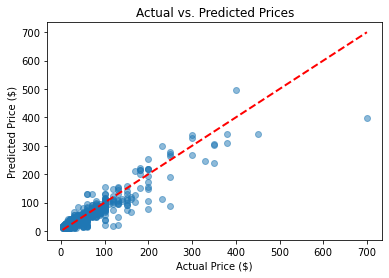

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     1731.
Date:                Mon, 06 Nov 2023   Prob (F-statistic):          1.67e-309
Time:                        17:41:18   Log-Likelihood:                -3887.5
No. Observations:                 905   AIC:                             7781.
Df Residuals:                     902   BIC:                             7795.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              12.0986      0.965     12.542      0.000      10.205      13.992
Pieces                  0.0806      0.001     57.769      0.000       0.078       0.083
Klassifisering_norm    -1.9555      0.757     -2.582      0.010      -3.442      -0.469
==============================================================================
Omnibus:                      453.470   Durbin-Watson:                   1.140
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5062.816
Skew:                           2.011   Prob(JB):                         0.00
Kurtosis:                      13.866   Cond. No.                     1.06e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
df2['Predicted_Price'] = results_mlr.predict(df2[['Pieces', 'Klassifisering_norm']])

plt.scatter(df2['Price'], df2['Predicted_Price'], alpha=0.5)
plt.plot([df2['Price'].min(), df2['Price'].max()], 
         [df2['Price'].min(), df2['Price'].max()], 
         '--', color='red', linewidth=2)
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Actual vs. Predicted Prices')
plt.show()

summary_mlr


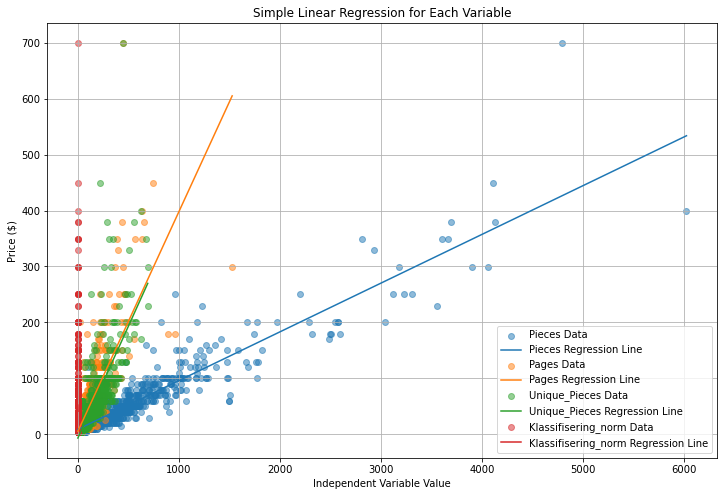

In [29]:
def simple_linear_regression(data, independent_var, dependent_var='Price'):
    # Define the formula for OLS regression
    formula = f'{dependent_var} ~ {independent_var}'
    # Fit the model
    model = smf.ols(formula, data=data).fit()
    return model

def plot_regression_line(data, independent_var, dependent_var='Price', model=None):
    if model is None:
        model = simple_linear_regression(data, independent_var, dependent_var)
    
    # Create a range of values for the independent variable
    x_range = np.linspace(data[independent_var].min(), data[independent_var].max(), 100)
    # Predict the dependent variable for the range of independent variable values
    y_range = model.params['Intercept'] + model.params[independent_var] * x_range
    
    # Plot the data points
    plt.scatter(data[independent_var], data[dependent_var], alpha=0.5, label=f'{independent_var} Data')
    # Plot the regression line
    plt.plot(x_range, y_range, label=f'{independent_var} Regression Line')



variables = ['Pieces', 'Pages', 'Unique_Pieces', "Klassifisering_norm"]
plt.figure(figsize=(12, 8))
for var in variables:
    model = simple_linear_regression(df2, var)
    plot_regression_line(df2, var, model=model)
plt.xlabel('Independent Variable Value')
plt.ylabel('Price ($)')
plt.title('Simple Linear Regression for Each Variable')
plt.legend()
plt.grid(True)
plt.show()
